In [2]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from rank_bm25 import BM25Okapi
from nltk.util import ngrams
import re
import string
from tqdm import tqdm
import os 
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter



# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords') 
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/oceanspiess/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/oceanspiess/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/oceanspiess/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/oceanspiess/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
data_folder_path = os.path.join('avis_trad')

dfs = []
for file_name in os.listdir(data_folder_path):
    path = os.path.join(data_folder_path, file_name)
    new_df = pd.read_excel(path)
    dfs.append(new_df)

df = pd.concat(dfs, ignore_index=True)

In [4]:
df[df['type'] == 'train'].head()

,note,auteur,avis,assureur,produit,type,date_publication,date_exp,avis_en,avis_cor,avis_cor_en
2000,5.0,claire-m-130353,"les prix au top, la facilité d'inscription et ...",Direct Assurance,auto,train,31/08/2021,01/08/2021,"top prices, ease of registration and clear ser...",NaN,NaN
2001,2.0,tontonlouis-90075,je n'ai pas les moyens d'attendre 3 à 4 semain...,Cegema Assurances,sante,train,30/05/2020,01/05/2020,I cannot afford to wait 3 to 4 weeks for reimb...,NaN,NaN
2002,1.0,fred78-132197,Je voulais assurer une Tesla Modèle 3 LR ...\n...,MACIF,auto,train,10/09/2021,01/09/2021,I wanted to ensure a Tesla Model 3 LR ...\nThe...,NaN,NaN
2003,1.0,sud-70690,"Je suis en arrêt de travail depuis nov 2017 ,a...",Cardif,credit,train,07/02/2019,01/02/2019,"I am on work stoppage since Nov 2017, assured ...",NaN,NaN
2004,1.0,fofi-80683,inadmissible... je leur ai réglé un trop perçu...,Harmonie Mutuelle,sante,train,04/11/2019,01/11/2019,Inadmissible ... I set them too perceived foll...,NaN,NaN


In [5]:
print(df.info())

print(f"\nNombre de lignes: {df.shape[0]}")
print(f"Nombre de colonnes: {df.shape[1]}")

print("\nRépartition des valeurs manquantes:")
print(df.isnull().sum())

print(f"\nNombre d'avis de type 'test': {len(df[df['type'] == 'test'])} \n")

print(df.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34435 entries, 0 to 34434
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   note              24104 non-null  float64
 1   auteur            34434 non-null  object 
 2   avis              34435 non-null  object 
 3   assureur          34435 non-null  object 
 4   produit           34435 non-null  object 
 5   type              34435 non-null  object 
 6   date_publication  34435 non-null  object 
 7   date_exp          34435 non-null  object 
 8   avis_en           34433 non-null  object 
 9   avis_cor          435 non-null    object 
 10  avis_cor_en       431 non-null    object 
dtypes: float64(1), object(10)
memory usage: 2.9+ MB
None

Nombre de lignes: 34435
Nombre de colonnes: 11

Répartition des valeurs manquantes:
note                10331
auteur                  1
avis                    0
assureur                0
produit                 0
type   

In [6]:
# Drop specified columns
df = df.drop(['avis_cor', 'avis_cor_en', 'auteur', 'date_publication', 'date_exp', 'produit'], axis=1)

# Remove rows where avis_en is null
df = df.dropna(subset=['avis_en'])

# Reset index after dropping rows
df = df.reset_index(drop=True)


In [7]:
# Split into train and test datasets based on 'type' column
train_df = df[df['type'] == 'train'].copy()
test_df = df[df['type'] == 'test'].copy()

# Drop 'type' column from both datasets
train_df = train_df.drop('type', axis=1)
test_df = test_df.drop('type', axis=1)

# Reset indices
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


In [8]:
train_df.head()

,note,avis,assureur,avis_en
0,5.0,"les prix au top, la facilité d'inscription et ...",Direct Assurance,"top prices, ease of registration and clear ser..."
1,2.0,je n'ai pas les moyens d'attendre 3 à 4 semain...,Cegema Assurances,I cannot afford to wait 3 to 4 weeks for reimb...
2,1.0,Je voulais assurer une Tesla Modèle 3 LR ...\n...,MACIF,I wanted to ensure a Tesla Model 3 LR ...\nThe...
3,1.0,"Je suis en arrêt de travail depuis nov 2017 ,a...",Cardif,"I am on work stoppage since Nov 2017, assured ..."
4,1.0,inadmissible... je leur ai réglé un trop perçu...,Harmonie Mutuelle,Inadmissible ... I set them too perceived foll...


In [9]:
print("\nNombre d'avis par assureur:")
print(train_df['assureur'].value_counts())


Nombre d'avis par assureur:
assureur
Direct Assurance        5896
L'olivier Assurance     4287
APRIL Moto              1023
GMF                      997
Néoliane Santé           861
MACIF                    829
AMV                      688
Santiane                 658
AXA                      629
MAAF                     612
MAIF                     591
Allianz                  574
Pacifica                 553
Matmut                   474
MGP                      446
Active Assurances        403
Ag2r La Mondiale         350
Harmonie Mutuelle        312
Eurofil                  289
APRIL                    283
Mercer                   267
Cardif                   265
Zen'Up                   245
Cegema Assurances        214
Génération               212
Mgen                     209
CNP Assurances           147
Crédit Mutuel            146
Afer                     144
SwissLife                138
Eca Assurances           132
Generali                 128
Mutuelle des Motards     128
Assur

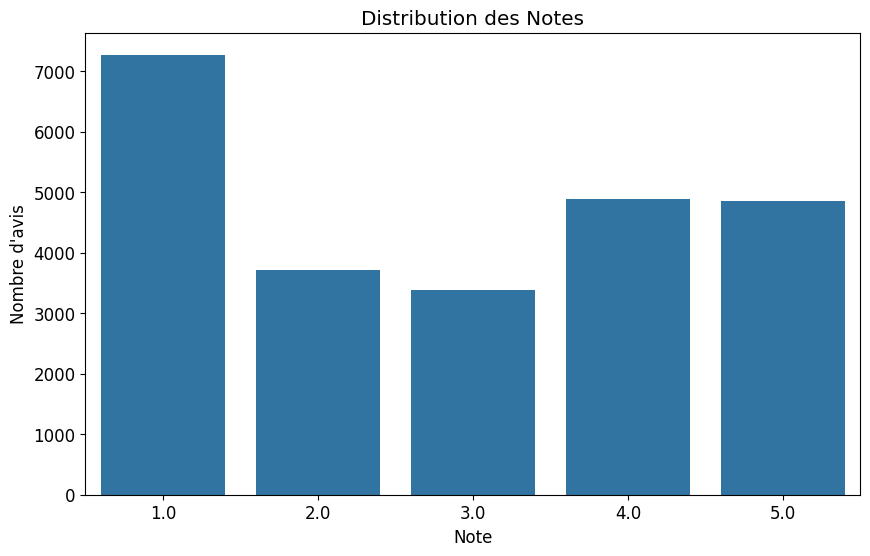

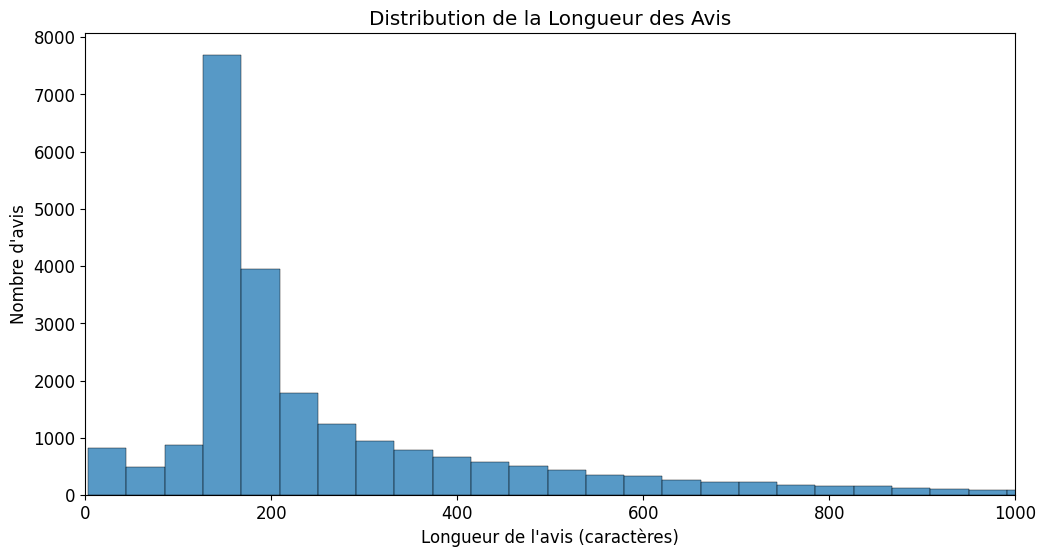

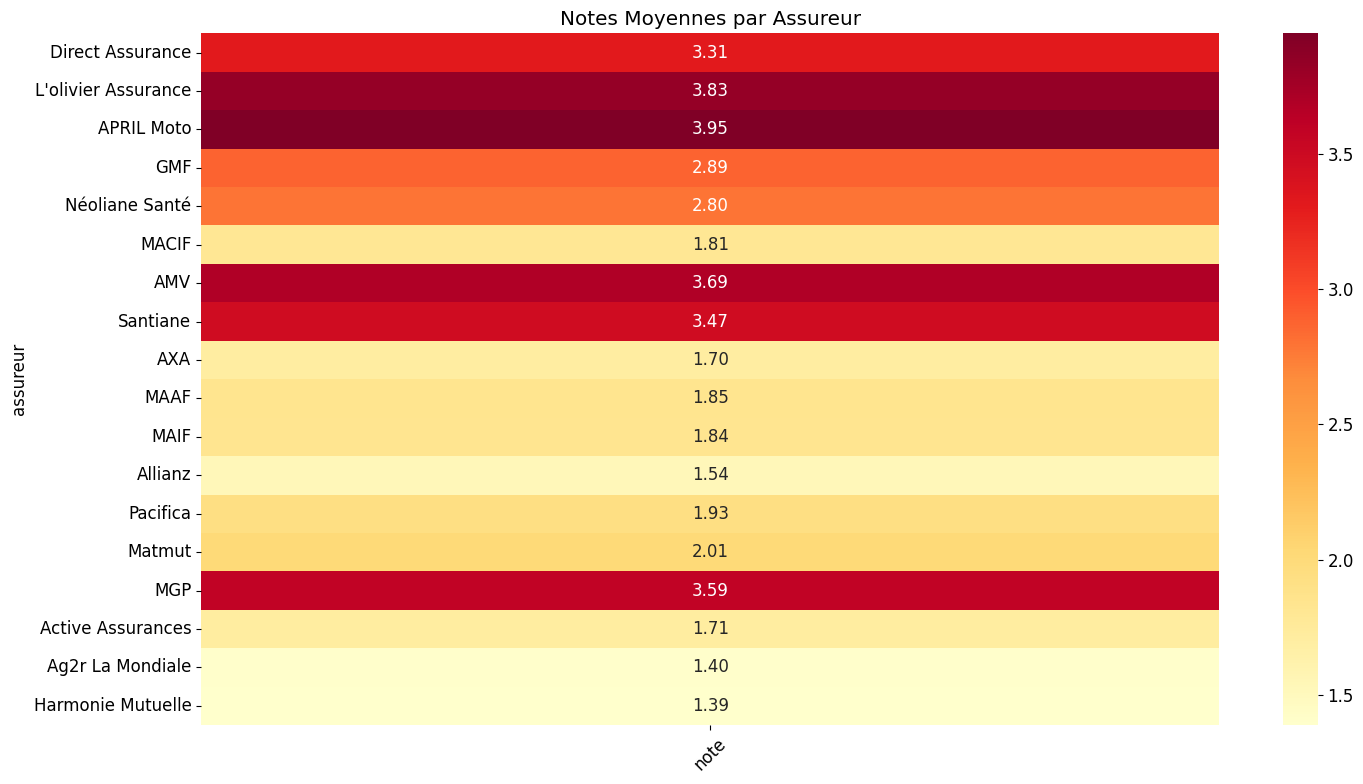

In [11]:
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# 1. Distribution des notes
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='note')
plt.title('Distribution des Notes')
plt.xlabel('Note')
plt.ylabel('Nombre d\'avis')
plt.show()

# 4. Distribution de la longueur des avis
plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x=train_df['avis_en'].str.len(), bins=200)
plt.title('Distribution de la Longueur des Avis')
plt.xlabel('Longueur de l\'avis (caractères)')
plt.ylabel('Nombre d\'avis')
plt.xlim(0, 1000)  # Limiter l'axe x pour une meilleure lisibilité
plt.show()

# 5. Heatmap des notes moyennes par assureur
plt.figure(figsize=(15, 8))
notes_moyennes = train_df.groupby('assureur')['note'].mean().to_frame()
# Filtrer pour n'avoir que les assureurs avec un nombre minimum d'avis
assureurs_frequents = train_df['assureur'].value_counts()[train_df['assureur'].value_counts() > 300].index
notes_moyennes = notes_moyennes.loc[assureurs_frequents]

sns.heatmap(notes_moyennes, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('Notes Moyennes par Assureur')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [12]:
# Fonction pour nettoyer le texte
def clean_text(text):
    # Convertir en minuscules
    text = text.lower()
    # Supprimer la ponctuation et les caractères spéciaux
    text = re.sub(r'[^\w\s]', ' ', text)
    # Supprimer les chiffres
    text = re.sub(r'\d+', '', text)
    # Supprimer les espaces multiples
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [13]:
# Fonction pour obtenir les n-grams les plus fréquents
def get_top_ngrams(texts, n, top_k=20):
    # Nettoyer et tokenizer tous les textes
    tokens_list = []
    for text in texts:
        clean = clean_text(text)
        tokens = word_tokenize(clean)
        # Filtrer les stop words
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]
        tokens_list.extend(tokens)
    
    # Créer les n-grams
    n_grams = list(ngrams(tokens_list, n))
    # Compter les fréquences
    freq_dist = Counter(n_grams)
    # Retourner les top_k plus fréquents
    return freq_dist.most_common(top_k)

In [14]:
# Analyse des mots fréquents dans les avis en anglais
print("\nAnalyse des mots fréquents dans les avis en anglais")
print("-" * 50)

# 1. Mots uniques (unigrams)
print("\nTop 20 mots les plus fréquents:")
unigrams = get_top_ngrams(train_df['avis_en'], 1)
for gram, count in unigrams:
    print(f"{gram[0]}: {count}")

# 2. Bigrams
print("\nTop 20 paires de mots (bigrams) les plus fréquentes:")
bigrams = get_top_ngrams(train_df['avis_en'], 2)
for gram, count in bigrams:
    print(f"{gram[0]} {gram[1]}: {count}")

# 3. Trigrams
print("\nTop 20 triplets de mots (trigrams) les plus fréquents:")
trigrams = get_top_ngrams(train_df['avis_en'], 3)
for gram, count in trigrams:
    print(f"{gram[0]} {gram[1]} {gram[2]}: {count}")


Analyse des mots fréquents dans les avis en anglais
--------------------------------------------------

Top 20 mots les plus fréquents:
insurance: 12694
service: 6649
satisfied: 5878
contract: 4978
price: 4802
years: 4078
good: 3824
customer: 3560
prices: 3359
without: 3248
well: 3025
vehicle: 2884
time: 2869
recommend: 2814
phone: 2781
months: 2703
since: 2683
year: 2662
car: 2629
file: 2378

Top 20 paires de mots (bigrams) les plus fréquentes:
customer service: 1680
satisfied service: 1479
direct insurance: 1255
recommend insurance: 494
insurance company: 476
car insurance: 428
satisfied price: 420
highly recommend: 399
non responsible: 387
olive tree: 387
satisfied services: 383
third party: 371
green card: 366
mutual insurance: 352
take care: 349
home insurance: 346
value money: 343
insurance contract: 329
life insurance: 324
simple practical: 317

Top 20 triplets de mots (trigrams) les plus fréquents:
mutual insurance company: 248
satisfied service prices: 233
good value money: 1

In [16]:
# Analyse de la longueur des mots
word_lengths = []
for text in train_df['avis_en']:
    clean = clean_text(text)
    tokens = word_tokenize(clean)
    word_lengths.extend([len(word) for word in tokens])

# Statistiques sur la longueur des mots
print("\nStatistiques sur la longueur des mots:")
print(f"Longueur moyenne: {np.mean(word_lengths):.2f}")
print(f"Longueur médiane: {np.median(word_lengths):.2f}")
print(f"Écart-type: {np.std(word_lengths):.2f}")
print(f"Longueur minimale: {min(word_lengths)}")
print(f"Longueur maximale: {max(word_lengths)}")

# Analyse des mots les plus longs
print("\nLes 5 mots les plus longs:")
all_words = []
for text in train_df['avis_en']:
    clean = clean_text(text)
    tokens = word_tokenize(clean)
    all_words.extend(tokens)

# Trier les mots par longueur et prendre les 5 plus longs
longest_words = sorted(set(all_words), key=len, reverse=True)[:5]
for word in longest_words:
    print(f"{word}: {len(word)} caractères")



Statistiques sur la longueur des mots:
Longueur moyenne: 4.50
Longueur médiane: 4.00
Écart-type: 2.83
Longueur minimale: 1
Longueur maximale: 990

Les 5 mots les plus longs:
satisfaitaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaacccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv

Analyse des avis en français:
Statistiques avant nettoyage:
Nombre total de mots: 1486777
Longueur moyenne: 4.50
Longueur maximale: 1045

Mots les plus longs trouvés:
satisfaitaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaacccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv

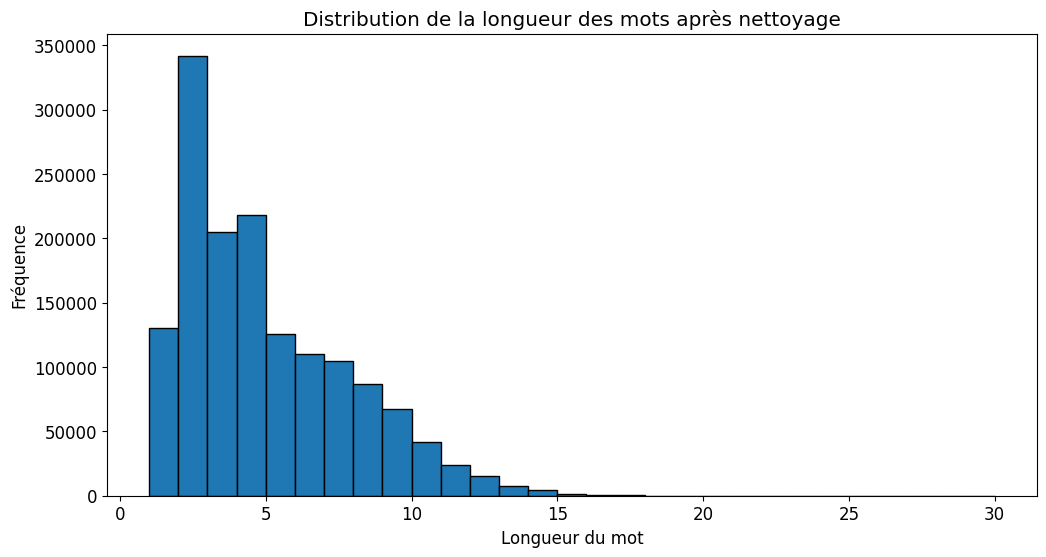

In [17]:
def analyze_word_lengths(text_series, max_length=25, tolerance=10):
    """
    Analyse et nettoie les mots trop longs
    max_length: longueur maximale acceptable pour un mot
    tolerance: nombre de caractères supplémentaires autorisés avant suppression
    """
    # Fonction pour traiter un texte
    def clean_long_words(text):
        if not isinstance(text, str):
            return text
        words = text.split()
        cleaned_words = []
        for word in words:
            # Enlever la ponctuation pour vérifier la vraie longueur du mot
            clean_word = re.sub(r'[^\w\s]', '', word)
            if len(clean_word) <= max_length + tolerance:
                cleaned_words.append(word)
            else:
                print(f"Mot supprimé (trop long): {word} ({len(clean_word)} caractères)")
        return ' '.join(cleaned_words)

    # Analyse avant nettoyage
    all_words = []
    for text in text_series:
        if isinstance(text, str):
            words = re.findall(r'\b\w+\b', text.lower())
            all_words.extend(words)

    word_lengths = [len(word) for word in all_words]
    
    print("Statistiques avant nettoyage:")
    print(f"Nombre total de mots: {len(all_words)}")
    print(f"Longueur moyenne: {np.mean(word_lengths):.2f}")
    print(f"Longueur maximale: {max(word_lengths)}")
    
    # Trouver les mots les plus longs
    long_words = [(word, len(word)) for word in all_words if len(word) > max_length]
    long_words.sort(key=lambda x: x[1], reverse=True)
    
    if long_words:
        print("\nMots les plus longs trouvés:")
        for word, length in long_words[:10]:  # Afficher les 10 plus longs mots
            print(f"{word}: {length} caractères")
    
    # Nettoyer les textes
    cleaned_series = text_series.apply(clean_long_words)
    
    # Analyse après nettoyage
    all_words_after = []
    for text in cleaned_series:
        if isinstance(text, str):
            words = re.findall(r'\b\w+\b', text.lower())
            all_words_after.extend(words)
    
    word_lengths_after = [len(word) for word in all_words_after]
    
    print("\nStatistiques après nettoyage:")
    print(f"Nombre total de mots: {len(all_words_after)}")
    print(f"Longueur moyenne: {np.mean(word_lengths_after):.2f}")
    print(f"Longueur maximale: {max(word_lengths_after)}")
    
    return cleaned_series

# Appliquer le nettoyage aux avis en français et en anglais
print("Analyse des avis en français:")
train_df['avis_cleaned'] = analyze_word_lengths(train_df['avis'], max_length=25, tolerance=10)

print("\nAnalyse des avis en anglais:")
train_df['avis_en_cleaned'] = analyze_word_lengths(train_df['avis_en'], max_length=25, tolerance=10)

# Visualiser la distribution des longueurs de mots après nettoyage
plt.figure(figsize=(12, 6))
word_lengths = []
for text in train_df['avis_cleaned']:
    if isinstance(text, str):
        words = re.findall(r'\b\w+\b', text.lower())
        word_lengths.extend([len(word) for word in words])

plt.hist(word_lengths, bins=range(1, max(word_lengths) + 2, 1), 
         edgecolor='black')
plt.title('Distribution de la longueur des mots après nettoyage')
plt.xlabel('Longueur du mot')
plt.ylabel('Fréquence')
plt.show()